# Store Item Demand Forecasting & Analysis (V2)

## Step 1: Data Loading & Initial Exploration

In [2]:
import pandas as pd

# Load the new V2 dataset
# Make sure the file is in the correct directory: 'V2/data/train.csv'
file_path = 'train.csv'
df_v2 = pd.read_csv(file_path)

# Display the first 5 rows to see what the data looks like
print("First 5 rows of the V2 dataset:")
print(df_v2.head())
print("\n" + "="*50 + "\n")

# Display the data types and check for missing values
print("Data information:")
print(df_v2.info())

First 5 rows of the V2 dataset:
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None


## Step 2: Data Cleaning & Preparation for Multi-Series Forecasting

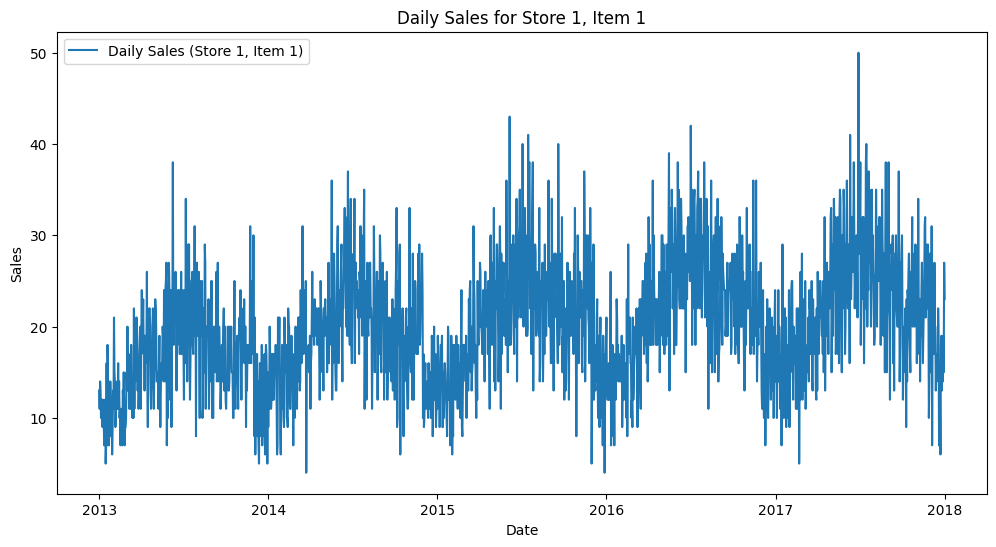

Data preparation for V2 is complete. The 'sample_df' is now ready for forecasting.
            store  item   y
ds                         
2013-01-01      1     1  13
2013-01-02      1     1  11
2013-01-03      1     1  14
2013-01-04      1     1  13
2013-01-05      1     1  10


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data Preparation ---
# Load the new V2 dataset
file_path = 'train.csv'
df_v2 = pd.read_csv(file_path)

# Convert the 'date' column to datetime
df_v2['date'] = pd.to_datetime(df_v2['date'])

# Aggregate daily sales for each store-item combination
daily_sales_v2 = df_v2.groupby(['store', 'item', 'date'])['sales'].sum().reset_index()

# Prepare one time series for visualization using .loc to avoid the warning
# I'm work on a specific copy of the slice
sample_df = daily_sales_v2.loc[(daily_sales_v2['store'] == 1) & (daily_sales_v2['item'] == 1)].copy()

# Rename columns to 'ds' and 'y' for Prophet
sample_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Now, let's set the date as the index
sample_df = sample_df.set_index('ds')

# --- Visualization ---
# Plot a single time series to see the trends and seasonality
plt.figure(figsize=(12, 6))
plt.plot(sample_df.index, sample_df['y'], label='Daily Sales (Store 1, Item 1)')
plt.title('Daily Sales for Store 1, Item 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print("Data preparation for V2 is complete. The 'sample_df' is now ready for forecasting.")
print(sample_df.head())

## Step 3: Forecasting with Prophet for V2. 
### (THIS IS IMPORTANT STEP SO RECHECK THE CODE AGAIN!)

In [8]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm # A library to show a progress bar

# Load the V2 dataset again to ensure a clean start
file_path = 'train.csv'
df_v2 = pd.read_csv(file_path)
df_v2['date'] = pd.to_datetime(df_v2['date'])

# Get a list of all unique store-item combinations
stores = df_v2['store'].unique()
items = df_v2['item'].unique()

# Create an empty list to store all the forecasts
all_forecasts = []

print("Starting multi-series forecasting. This may take a few minutes...")

# Loop through each store and item
for store in tqdm(stores):
    for item in items:
        # Filter the data for the current store and item
        time_series = df_v2[(df_v2['store'] == store) & (df_v2['item'] == item)]
        
        # Prepare the data for Prophet by renaming columns
        time_series = time_series.rename(columns={'date': 'ds', 'sales': 'y'})
        
        # Initialize and fit the Prophet model
        m = Prophet()
        m.fit(time_series)
        
        # Create a future dataframe for the next 365 days
        future = m.make_future_dataframe(periods=365)
        
        # Generate the forecast
        forecast = m.predict(future)
        
        # Add the store and item ID to the forecast DataFrame for tracking
        forecast['store'] = store
        forecast['item'] = item
        
        # Append the forecast to our list
        all_forecasts.append(forecast)

print("All forecasts generated. Combining results...")

# Concatenate all forecasts into a single DataFrame
forecast_df = pd.concat(all_forecasts)

print("\nForecasting for all 500 time series is complete.")
print("\nFirst 5 rows of the combined forecast DataFrame:")
print(forecast_df[['ds', 'store', 'item', 'yhat']].head())

Starting multi-series forecasting. This may take a few minutes...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]01:31:01 - cmdstanpy - INFO - Chain [1] start processing
01:31:01 - cmdstanpy - INFO - Chain [1] done processing
01:31:02 - cmdstanpy - INFO - Chain [1] start processing
01:31:02 - cmdstanpy - INFO - Chain [1] done processing
01:31:03 - cmdstanpy - INFO - Chain [1] start processing
01:31:03 - cmdstanpy - INFO - Chain [1] done processing
01:31:04 - cmdstanpy - INFO - Chain [1] start processing
01:31:04 - cmdstanpy - INFO - Chain [1] done processing
01:31:04 - cmdstanpy - INFO - Chain [1] start processing
01:31:05 - cmdstanpy - INFO - Chain [1] done processing
01:31:05 - cmdstanpy - INFO - Chain [1] start processing
01:31:05 - cmdstanpy - INFO - Chain [1] done processing
01:31:06 - cmdstanpy - INFO - Chain [1] start processing
01:31:06 - cmdstanpy - INFO - Chain [1] done processing
01:31:07 - cmdstanpy - INFO - Chain [1] start processing
01:31:07 - cmdstanpy - INFO - Cha

All forecasts generated. Combining results...

Forecasting for all 500 time series is complete.

First 5 rows of the combined forecast DataFrame:
          ds  store  item       yhat
0 2013-01-01      1     1   8.646726
1 2013-01-02      1     1   9.306336
2 2013-01-03      1     1   9.983400
3 2013-01-04      1     1  11.548046
4 2013-01-05      1     1  13.491892


## Step 4: Model Validation with Backtesting.          
---
### This is what separates a simple forecast from a robust, production-ready model.

### Why Backtesting?

### A simple train-test split (like in V1) only validates Sales Forecasting Model on one period in time. Backtesting, also known as rolling-origin validation, systematically trains and tests your model over multiple periods in the past. This proves that your model is consistently accurate, not just lucky.     

----

### Step 4.1: Performing Cross-Validation and Backtesting

In [10]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm

# Load the V2 dataset again for a clean start
file_path = 'train.csv'
df_v2 = pd.read_csv(file_path)
df_v2['date'] = pd.to_datetime(df_v2['date'])

# Select a single time series to demonstrate backtesting
sample_df = df_v2[(df_v2['store'] == 1) & (df_v2['item'] == 1)].copy()
sample_df = sample_df.rename(columns={'date': 'ds', 'sales': 'y'})

# Initialize and fit the Prophet model
m = Prophet()
m.fit(sample_df)

# --- Perform Cross-Validation ---
# We will do a rolling-origin validation
# 'initial' is the size of the first training period (e.g., 3 years)
# 'period' is the gap between cutoff dates (e.g., 6 months)
# 'horizon' is the forecast period (e.g., 3 months)

print("Starting cross-validation for a sample time series. This may take a few moments...")
df_cv = cross_validation(m, initial='1095 days', period='180 days', horizon='90 days')

print("\nCross-validation complete. Calculating performance metrics...")
df_p = performance_metrics(df_cv)

print("\nPerformance Metrics for Sample Time Series:")
print(df_p.head())

01:47:24 - cmdstanpy - INFO - Chain [1] start processing
01:47:25 - cmdstanpy - INFO - Chain [1] done processing


Starting cross-validation for a sample time series. This may take a few moments...


  0%|          | 0/4 [00:00<?, ?it/s]

01:47:25 - cmdstanpy - INFO - Chain [1] start processing
01:47:25 - cmdstanpy - INFO - Chain [1] done processing
01:47:25 - cmdstanpy - INFO - Chain [1] start processing
01:47:25 - cmdstanpy - INFO - Chain [1] done processing
01:47:25 - cmdstanpy - INFO - Chain [1] start processing
01:47:26 - cmdstanpy - INFO - Chain [1] done processing
01:47:26 - cmdstanpy - INFO - Chain [1] start processing
01:47:26 - cmdstanpy - INFO - Chain [1] done processing



Cross-validation complete. Calculating performance metrics...

Performance Metrics for Sample Time Series:
  horizon        mse      rmse       mae      mape     mdape     smape  \
0  9 days  24.462061  4.945914  3.963914  0.214989  0.156024  0.188085   
1 10 days  25.583283  5.057992  4.140029  0.224614  0.167963  0.196418   
2 11 days  22.634945  4.757620  3.829653  0.209121  0.150228  0.181629   
3 12 days  23.424111  4.839846  3.905273  0.218081  0.157991  0.188068   
4 13 days  23.795459  4.878059  3.892020  0.211356  0.133548  0.185066   

   coverage  
0  0.694444  
1  0.666667  
2  0.722222  
3  0.694444  
4  0.694444  


 ### ---> RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error) for different forecast horizons. This demonstrates my forecast model's accuracy is robust over time. 

### Step 4.2: Visualizing Backtesting Results

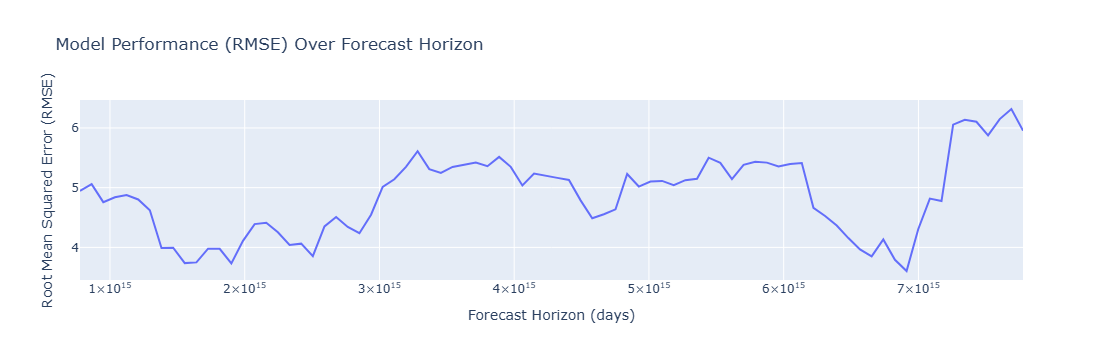

Backtesting visualization complete. The interactive plot shows your model's performance over time.


In [11]:
import plotly.express as px
from prophet.diagnostics import performance_metrics

# Re-run performance_metrics with the cross-validation results
df_p = performance_metrics(df_cv)

# Create an interactive plot of the performance metrics
fig = px.line(
    df_p,
    x="horizon",
    y="rmse",
    title="Model Performance (RMSE) Over Forecast Horizon",
    labels={"horizon": "Forecast Horizon (days)", "rmse": "Root Mean Squared Error (RMSE)"}
)
fig.show()

print("Backtesting visualization complete. The interactive plot shows your model's performance over time.")